In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
from UnFaIRv2_0 import *
import scipy as sp
import pickle
import time

In [16]:
emission_input = pd.read_pickle('./Sample_data/best_estimate_emissions.pkl')

otherforc = return_empty_forcing(emission_input.index[0],emission_input.index[-1],scen_names=emission_input.columns.levels[0])

RCP_forcing = pd.read_csv('/home/nleach/Documents/UnFaIR v2/UnFaIRv2.0/Sample_data/RCP85_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

otherforc.loc[:,('best_estimate','forcing')] = (RCP_forcing['TOTAL_INCLVOLCANIC_RF'] - RCP_forcing['CO2CH4N2O_RF']).loc[:2012]

gas_params = default_gas_forcing_params()

thermal_params = default_thermal_params()

gas_uncert = default_gas_forcing_param_uncertainty()

thermal_uncert = default_thermal_param_uncertainty()

gas_param_set = draw_monte_carlo_param_set(0,gas_params,gas_uncert,type='normal')

thermal_param_set = draw_monte_carlo_param_set(500,thermal_params,thermal_uncert,type='lognormal')

starttime=time.time()
model_output = run_UnFaIR(emission_input,otherforc,gas_parameters=gas_param_set,thermal_parameters=thermal_param_set)
print(time.time()-starttime)

Integrating 1 scenarios, 1 gas cycle parameter sets, 500 thermal response parameter sets, over ['CO2', 'CH4', 'N2O'], between 1765 and 2012...
0.6555767059326172


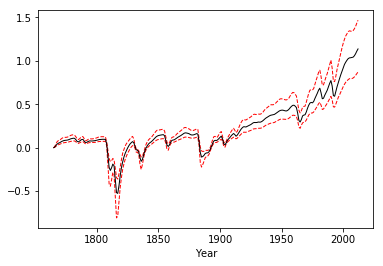

In [17]:
model_output['T'].xs('median',level=1,axis=1).quantile(0.16,axis=1).plot(legend=None,color='r',linewidth=1,linestyle='--')
model_output['T'].xs('median',level=1,axis=1).quantile(0.84,axis=1).plot(legend=None,color='r',linewidth=1,linestyle='--')
model_output['T'].xs('median',level=1,axis=1).median(axis=1).plot(legend=None,color='k',linewidth=1,linestyle='-')

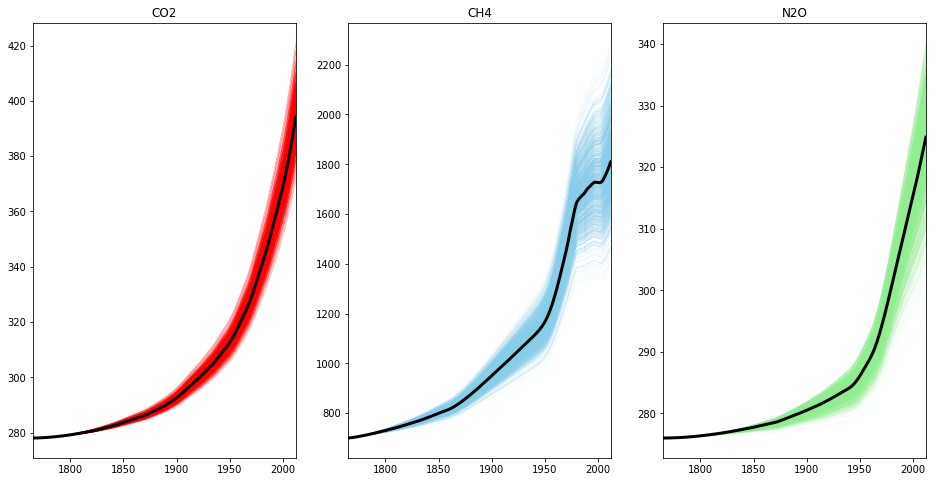

In [73]:
fig,ax=plt.subplots(1,3,figsize=(16,8))
colors = {'CO2':'r','CH4':'skyblue','N2O':'lightgreen'}
for i,s in enumerate(['CO2','CH4','N2O']):
    model_output['C'].xs(s,level=3,axis=1).plot(ax=ax[i],legend=None,color=colors[s],linewidth=0.1)
    model_output['C'].xs(('median',s),level=(1,3),axis=1).plot(ax=ax[i],legend=None,color='k',linewidth=3)
    ax[i].set_xlim(1765,2012)
    ax[i].set_title(s)